In [57]:
# librerias basicas
import os
import numpy as np
from copy import deepcopy
from tqdm import tqdm as tqdm
import time
import gc
# graficos
import matplotlib.cm as cm
import matplotlib.pyplot as plt
# videos
import cv2
# Imagenes medicas
import nibabel as nib
# optimizacion
import scipy.linalg
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.stats import linregress
# cargar data
import pickle as pkl
import warnings
# eliminar advertencias
warnings.filterwarnings('ignore')

In [58]:
def geo_mean(iterable):
  """
  Compute geometric mean of an array
  """
  a = np.array(iterable)
  return a.prod()**(1.0/len(a))
  
def read_image_data(path, file):
  """
  Read an image from the MNI atlas
  """
  img = nib.load(os.path.join(path, file))
  data = img.get_fdata()
  return data

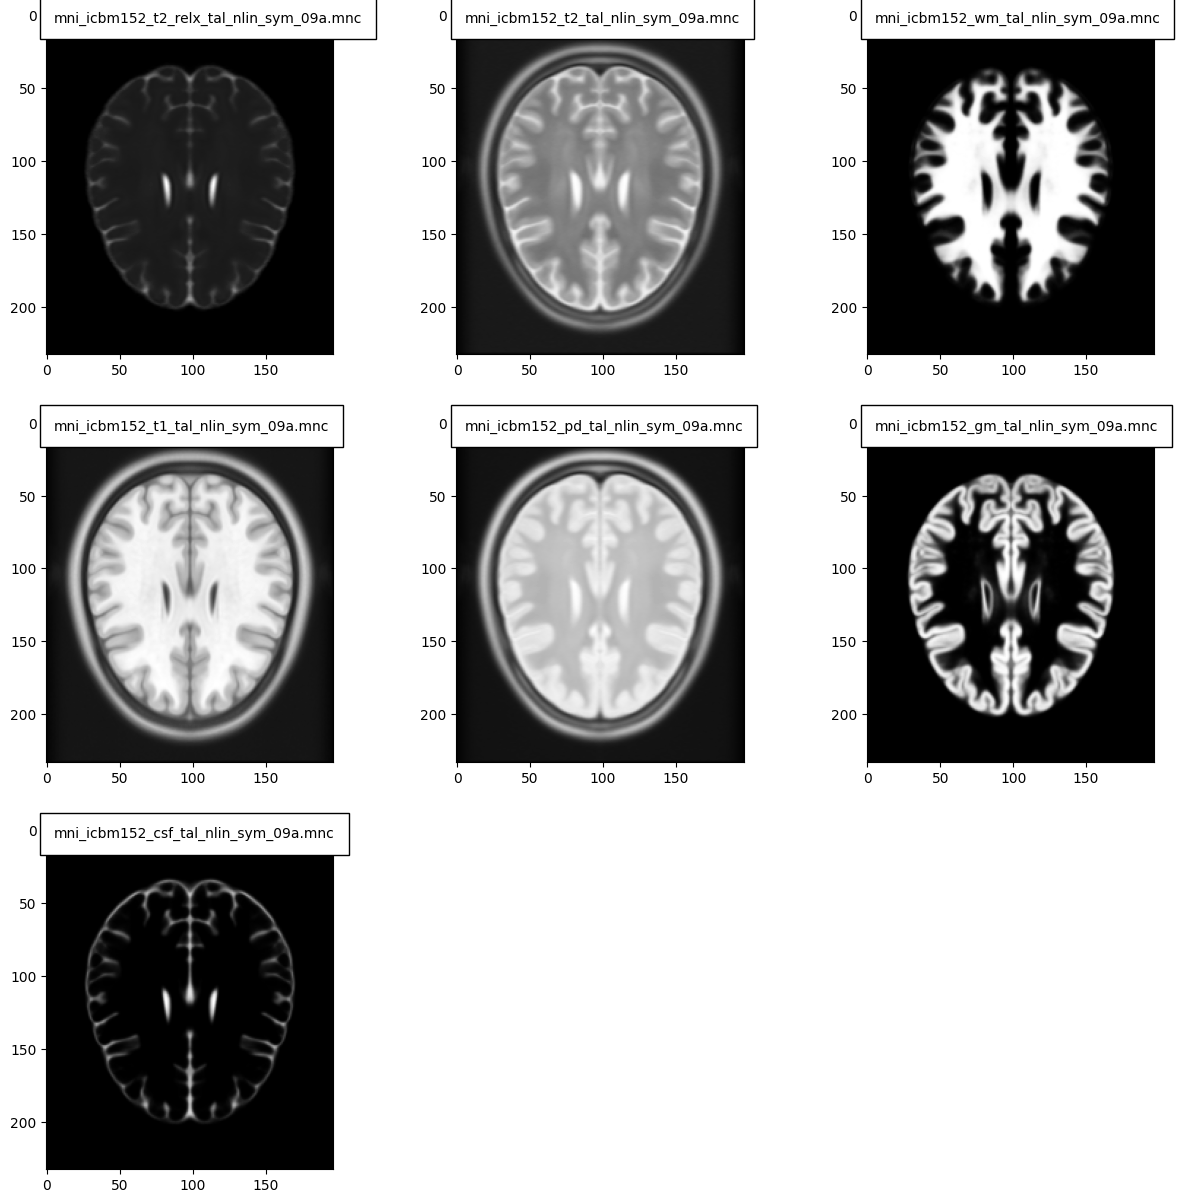

In [59]:
path = '/Users/Maxy/Desktop/tumor_growth/mni_icbm152_nlin_sym_09a_minc2'
files = ['mni_icbm152_t2_relx_tal_nlin_sym_09a.mnc',
         'mni_icbm152_t2_tal_nlin_sym_09a.mnc',
         'mni_icbm152_wm_tal_nlin_sym_09a.mnc',
         'mni_icbm152_t1_tal_nlin_sym_09a.mnc',
         'mni_icbm152_pd_tal_nlin_sym_09a.mnc',
         'mni_icbm152_gm_tal_nlin_sym_09a.mnc',
         'mni_icbm152_csf_tal_nlin_sym_09a.mnc']
f, ax = plt.subplots(3, 3, figsize=(15,15))
for i, file in enumerate(files):
  k, l = i//3, i%3
  data = read_image_data(path, file)
  ax[k, l].imshow(data[100], cmap="gray")
  ax[k, l].grid(False)
  ax[k, l].text(5, 5, file, bbox={'facecolor': 'white', 'pad': 10})
ax[-1, -2].axis('off')  
ax[-1, -1].axis('off')
f.show()

In [60]:
from scipy.ndimage import zoom
# Definimos los diferentes tipos de tejidos
white_matter = 'mni_icbm152_wm_tal_nlin_sym_09a.mnc'
grey_matter = 'mni_icbm152_gm_tal_nlin_sym_09a.mnc'
csf = 'mni_icbm152_csf_tal_nlin_sym_09a.mnc'
outside_lim = 'mni_icbm152_t2_relx_tal_nlin_sym_09a.mnc'
scale_factors = (70 / 189, 1, 1)
# Leer las imágenes utilizando la ruta proporcionada y los nombres de archivo 
#NOTA: La reescalo porque es mucho tiempo de procesamiento 
img = zoom(read_image_data(path, 'mni_icbm152_t1_tal_nlin_sym_09a.mnc'),scale_factors, order=3) 
wm = zoom(read_image_data(path, white_matter),scale_factors, order=3) 
gm = zoom(read_image_data(path, grey_matter),scale_factors, order=3)
csf = zoom(read_image_data(path, csf),scale_factors, order=3)
out = zoom(read_image_data(path, outside_lim),scale_factors, order=3)

img2=read_image_data(path, 'mni_icbm152_t1_tal_nlin_sym_09a.mnc')
# Función para normalizar un solo frame de la imagen
def normalize_frame_2D(i, img):
    # Crear una copia del frame i de la imagen
    img_norm = img[i].copy()
    
    # Establecemos todos los valores menores a 30 en 0
    zero_index = np.where(img_norm < 30)
    img_norm[zero_index] = 0
    
    # Normalizamos los valores de los píxeles al rango [0, 1]
    img_norm = (img_norm - np.min(img_norm)) / (np.max(img_norm) - np.min(img_norm))
    
    # Establecemos regiones específicas de la imagen en diferentes valores según umbrales

    # Indico la región fuera del cerebro en 0
    out_index = np.where(out[i] < 0.08)
    # Indico la región del LCR (líquido cefalorraquídeo) en 0
    csf_index = np.where(csf[i] > 0.15)
    # Indico la región de materia blanca en 1
    wm_index = np.where(wm[i] > 0.5)
    img_norm[out_index], img_norm[csf_index], img_norm[wm_index] = 0, 0, 1
    
    # Establecer la región de materia gris en 0.5
    gm_index = np.where(np.logical_and(img_norm > 0, img_norm < 1))
    img_norm[gm_index] = 0.5
    
    return img_norm

# Función para normalizar todo el volumen de la imagen de RM
def normalize_MRI(img):
    # Crear una copia del volumen completo de la imagen
    new_img = img.copy()
    
    # Normalizar cada frame del volumen de la imagen
    for i in range(img.shape[0]):
        new_img[i] = normalize_frame_2D(i, img)
    
    return new_img

# Función para comparar un frame específico antes y después de la normalización
def compare_with_norm(i, img):
    # Crear una figura con dos subplots
    f, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    # Mostrar el frame original antes de la normalización
    ax[0].imshow(1 - img[i], label='Antes de la normalización', cmap="gray")
    ax[0].grid(False)
    ax[0].text(5, 5, 'Imagen cruda ' + str(i), bbox={'facecolor': 'white', 'pad': 10})
    
    # Normalizar el frame
    img_norm = normalize_frame_2D(i, img)
    
    # Mostrar el frame después de la normalización
    ax[1].imshow(1 - img_norm, label='Después de la normalización', cmap= "gray")
    ax[1].text(5, 5, 'Imagen binaria ' + str(i), bbox={'facecolor': 'white', 'pad': 10})
    ax[1].grid(False)
    
    # Mostrar la figura
    f.show()



In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
import matplotlib.cm as cm
from scipy.sparse import lil_matrix

# Dentro de tu clase CNicholsonIRM


import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from matplotlib import cm

class CNicholsonIRM3D:
    def __init__(self, IRM, d_w=0.1, x0=[10, 60, 110], rho=0.18, dt=0.1, T=10, sigma=1e-3, theta=0.5):
        # Inicialización de parámetros del modelo
        self.IRM = IRM # Recibo la resonancia magnética completa en 3D
        self.x0 = x0  # Punto inicial para la condición inicial
        self.i_csf, self.j_csf, self.k_csf = np.where(self.IRM == 0)  # Índices para el CSF (fluido cerebroespinal)
        self.i_w, self.j_w, self.k_w = np.where(self.IRM == 1)  # Índices para la sustancia blanca
        self.i_g, self.j_g, self.k_g = np.where(self.IRM == 0.5)  # Índices para la sustancia gris
        self.D_w = d_w  # Difusividad en la sustancia blanca
        self.D_g = d_w / 10  # Difusividad en la sustancia gris
        self.rho = rho  # Tasa de crecimiento del tumor
        self.Lx, self.Ly, self.Lz = self.IRM.shape  # Dimensiones del IRM
        self.Nx, self.Ny, self.Nz, self.N = self.Lx, self.Ly, self.Lz, (self.Lx)*(self.Ly)*(self.Lz)  # Tamaño de la malla
        self.x, self.y, self.z = np.arange(0, self.Lx), np.arange(0, self.Ly), np.arange(0, self.Lz)  # Coordenadas x, y y z
        self.dx, self.dy, self.dz = self.x[1] - self.x[0], self.y[1] - self.y[0], self.z[1] - self.z[0]  # Paso de la malla en x, y y z
        self.dt, self.T, self.Nt = dt, T, int(round(T/float(dt)))  # Paso de tiempo y número de pasos
        self.t = np.linspace(0, self.Nt*dt, self.Nt+1)  # Vector de tiempo
        self.theta = theta  # Parámetro de Crank-Nicholson
        self.sigma = sigma  # Parámetro para la condición inicial
        self.Fx_g = self.D_g*self.dt/self.dx**2  # Factor de difusión en x para la sustancia gris
        self.Fy_g = self.D_g*self.dt/self.dy**2  # Factor de difusión en y para la sustancia gris
        self.Fz_g = self.D_g*self.dt/self.dz**2  # Factor de difusión en z para la sustancia gris
        self.Fx_w = self.D_w*self.dt/self.dx**2  # Factor de difusión en x para la sustancia blanca
        self.Fy_w = self.D_w*self.dt/self.dy**2  # Factor de difusión en y para la sustancia blanca
        self.Fz_w = self.D_w*self.dt/self.dz**2  # Factor de difusión en z para la sustancia blanca
        self.A = lil_matrix((self.N, self.N))  # Matriz del sistema lineal
        self.b = np.zeros(self.N)  # Vector del sistema lineal
        self.u = self.init()  # Condición inicial del sistema
        self.images = []  # Lista para guardar las imágenes

    def I(self, x, y, z):
        # Función para la condición inicial
        l = np.linalg.norm(np.array([x, y, z])-np.array(self.x0), 2)
        return np.exp(-l**2 / self.sigma)

    def init(self):
        # Inicialización de la matriz u
        u = np.empty((self.Nt+1, self.Nx, self.Ny, self.Nz))
        # Condición inicial
        for i, j, k in zip(self.i_w, self.j_w, self.k_w):
            u[0, i, j, k] = self.I(self.x[i], self.y[j], self.z[k])
        for i, j, k in zip(self.i_g, self.j_g, self.k_g):
            u[0, i, j, k] = self.I(self.x[i], self.y[j], self.z[k])
        return u

    def build_A_b(self, ijk, Fx, Fy, Fz, theta, D, t):
        for i, j, k in zip(ijk[0], ijk[1], ijk[2]):
            p = self.m(i, j, k)
            if k > 0:
                self.A[p, self.m(i, j, k-1)] = -theta * Fz
            if j > 0:
                self.A[p, self.m(i, j-1, k)] = -theta * Fy
            if i > 0:
                self.A[p, self.m(i-1, j, k)] = -theta * Fx
            self.A[p, p] = 1 + 2*theta*(Fx + Fy + Fz)
            if i < self.Nx - 1:
                self.A[p, self.m(i+1, j, k)] = -theta * Fx
            if j < self.Ny - 1:
                self.A[p, self.m(i, j+1, k)] = -theta * Fy
            if k < self.Nz - 1:
                self.A[p, self.m(i, j, k+1)] = -theta * Fz

    def m(self, i, j, k):
        return i*self.Ny*self.Nz + j*self.Nz + k

    def simulation(self):
        # Configurar A y b para CSF (fluido cerebroespinal)
        for i, j, k in zip(self.i_csf, self.j_csf, self.k_csf):
            p = self.m(i, j, k)
            self.A[p, p] = 1  # Diagonal principal

        # Configuramos A y b para sustancia blanca
        self.build_A_b((self.i_w, self.j_w, self.k_w), self.Fx_w, self.Fy_w, self.Fz_w, self.theta, self.D_w, 0)

        # Configuramos A y b para sustancia gris
        self.build_A_b((self.i_g, self.j_g, self.k_g), self.Fx_g, self.Fy_g, self.Fz_g, self.theta, self.D_g, 0)

        # Convertimos A a un formato CSR para eficiencia de cálculo
        self.A = self.A.tocsr()

        # Resolvemos el sistema lineal usando scipy.sparse.linalg.spsolve
        for t in range(self.Nt):
            # Construir vector b
            self.b.fill(0.0)  # Reiniciar b a cero
            # Configurar b para CSF (fluido cerebroespinal)
            for i, j, k in zip(self.i_csf, self.j_csf, self.k_csf):
                self.b[self.m(i, j, k)] = 0  # Para CSF, b[p] = 0
            
            # Configuramos b para sustancia blanca
            self.build_b((self.i_w, self.j_w, self.k_w), self.Fx_w, self.Fy_w, self.Fz_w, self.theta, t)

            # Configuramos b para sustancia gris
            self.build_b((self.i_g, self.j_g, self.k_g), self.Fx_g, self.Fy_g, self.Fz_g, self.theta, t)

            # Resolvemos el sistema lineal
            u_star = spsolve(self.A, self.b)

            # Actualizamos u para el siguiente paso de tiempo
            self.u[t+1] = u_star.reshape((self.Nx, self.Ny, self.Nz))
            if t % 10 == 0:
                self.viz([t])
                plt.show()
                self.save([t])

    def build_b(self, ijk, Fx, Fy, Fz, theta, t):
        for i, j, k in zip(ijk[0], ijk[1], ijk[2]):
            p = self.m(i, j, k)
            sum_fx = Fx * (self.u[t, min(i+1, self.Nx-1), j, k] - 2*self.u[t, i, j, k] + self.u[t, max(i-1, 0), j, k])
            sum_fy = Fy * (self.u[t, i, min(j+1, self.Ny-1), k] - 2*self.u[t, i, j, k] + self.u[t, i, max(j-1, 0), k])
            sum_fz = Fz * (self.u[t, i, j, min(k+1, self.Nz-1)] - 2*self.u[t, i, j, k] + self.u[t, i, j, max(k-1, 0)])
            
            self.b[p] = self.u[t, i, j, k] + (1 - theta) * (sum_fx + sum_fy + sum_fz) + self.dt * self.rho * (self.u[t, i, j, k] * (1 - self.u[t, i, j, k]))
    def viz(self, frames):
        for t in frames: 
            u = self.u[t]
            fig, ax = plt.subplots(1, 3, figsize=(18, 18))
            v1b = np.ma.masked_array(u[10,:,:], u[10, :, :]<0.01)
            pa = ax[0].imshow(1-img[37, 35:210, 25:170], interpolation='gaussian', cmap=cm.Greys)
            pb = ax[0].imshow(v1b, interpolation='gaussian', cmap=cm.Reds)
            ax[0].set_title(r'$D={0:1.2f} \, \, , \, \, \rho={1:0.2f}$ , t={2:1.1f} days'.format(self.D_w, self.rho, t*self.dt))
            ax[0].grid(False)
            ax[0].axis('off')
            pa = ax[1].imshow(1-self.IRM[10], interpolation='gaussian', cmap=cm.Greys)
            pb = ax[1].imshow(v1b, interpolation='gaussian', cmap=cm.Reds)
            ax[1].set_title(r'$D={0:1.2f} \, \, , \, \, \rho={1:0.2f}$ , t={2:1.1f} days'.format(self.D_w, self.rho, t*self.dt))
            ax[1].grid(False)
            ax[1].axis('off')
            pa = ax[2].imshow(1-img[37, 35:210, 25:170], interpolation='gaussian', cmap=cm.Greys)
            pc = ax[2].contour(u[10, :, :], levels=[0.16 * u[10, :, :].max(), 0.8 * u[10, :, :].max()], colors=['red', 'orange'], alpha=0.5)
            ax[2].set_title(r'$D={0:1.2f} \, \, , \, \, \rho={1:0.2f}$ , t={2:1.1f} days'.format(self.D_w, self.rho, t*self.dt))
            ax[2].grid(False)
            ax[2].axis('off')
            fig.savefig('/Users/Maxy/Desktop/tumor_growth/MEDICAL_IMAGE_ANALYSIS/CN3D_image{}_rho_{}_t{}days.jpg'.format(self.D_w, self.rho, t*self.dt), dpi=400)
    def save(self, frames):
        for t in frames:
            epoch_slices = []
            for k in range(21):
                u = self.u[t]
                brain_slice = 1-self.IRM[k]
                tumor_slice = np.zeros_like(brain_slice)

                mask = u[k, :, :] >= 0.01
                tumor_slice[mask] = u[k, :, :][mask]

                combined = np.stack((brain_slice, tumor_slice), axis=-1)
                epoch_slices.append(combined)
            self.images.append(epoch_slices)

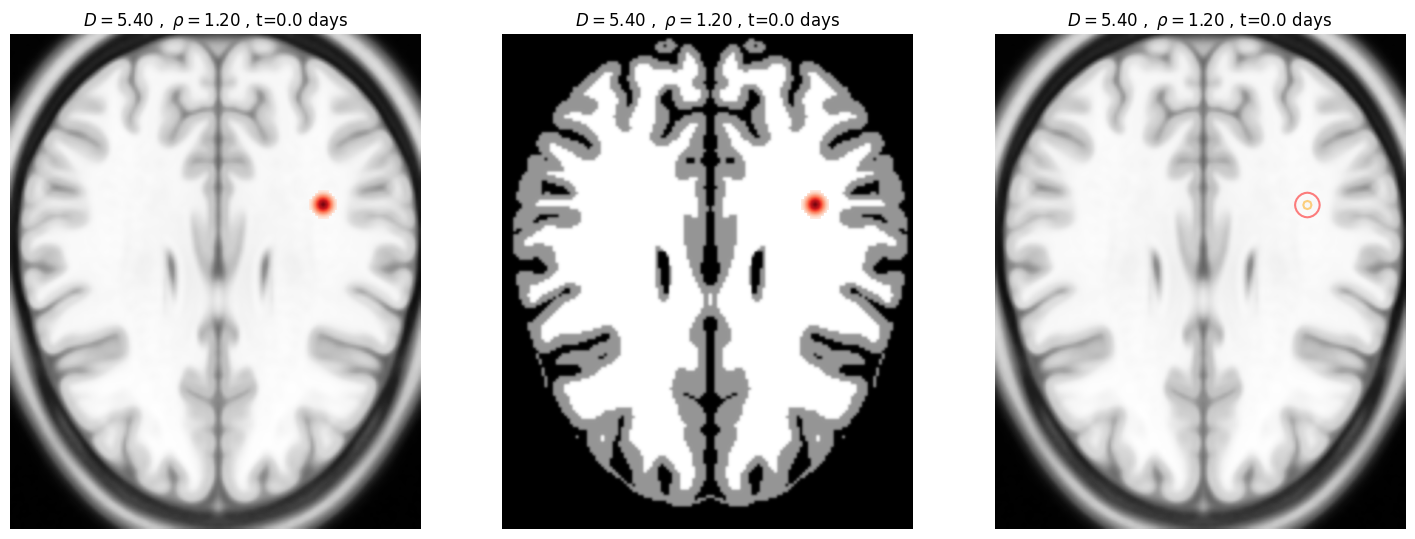

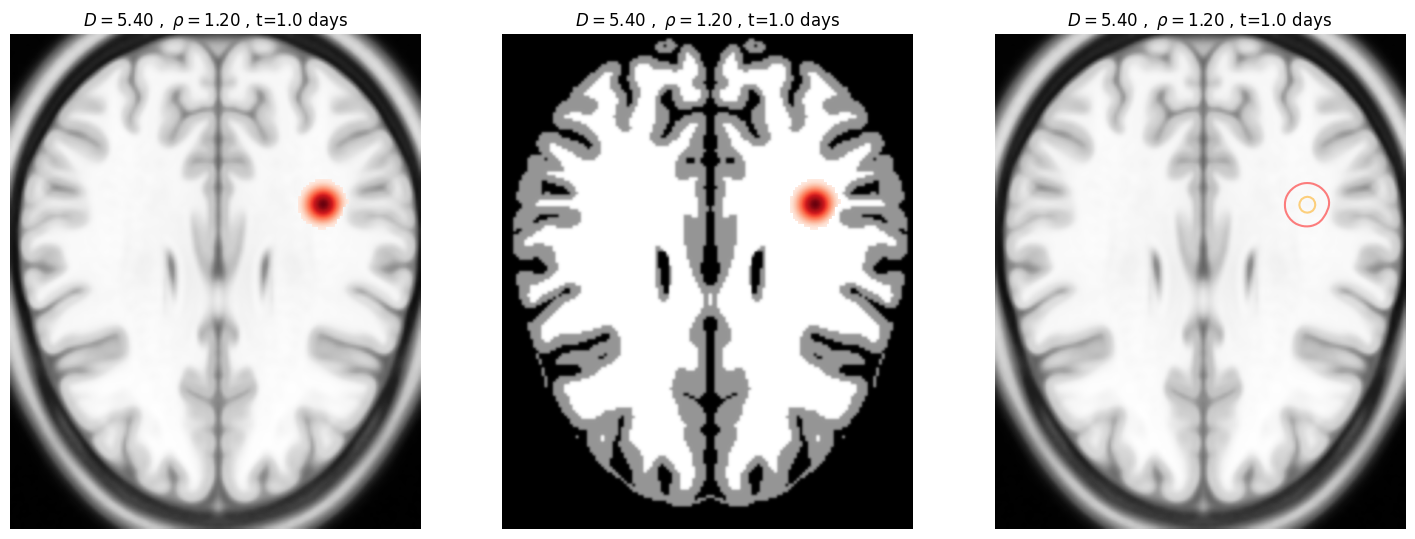

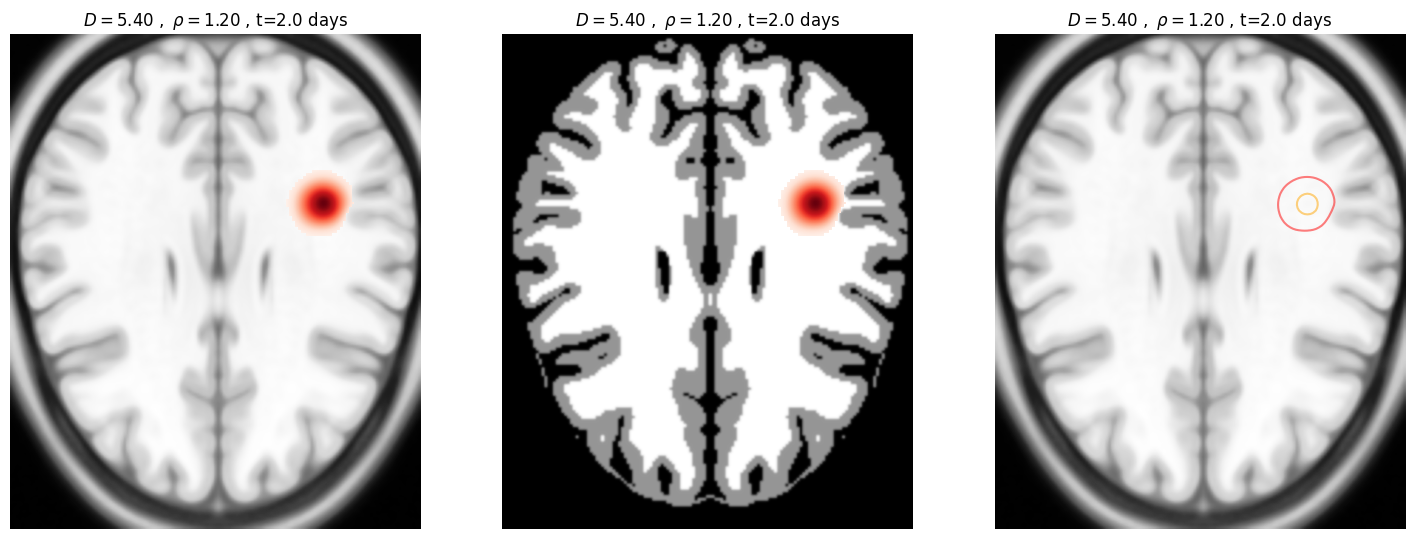

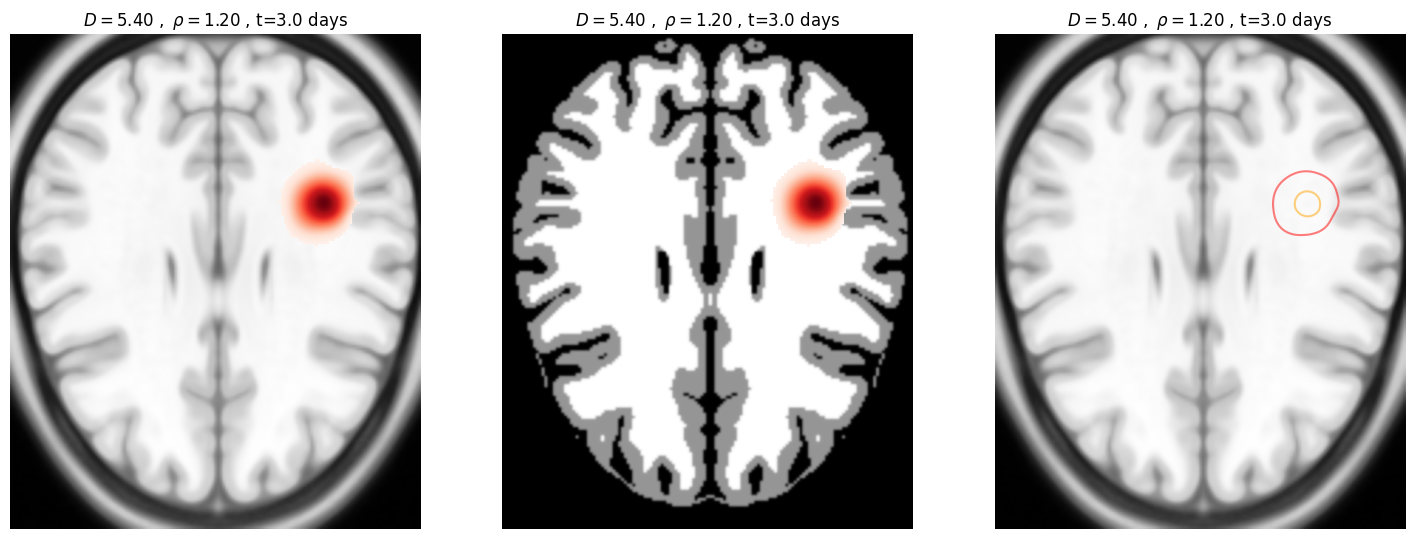

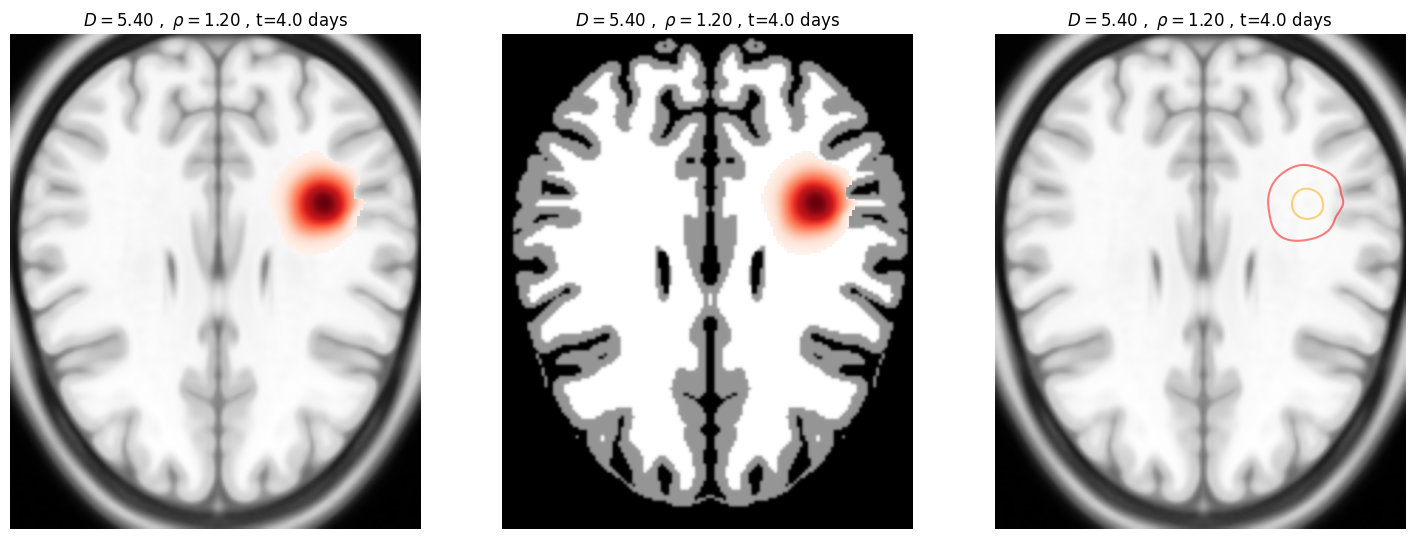

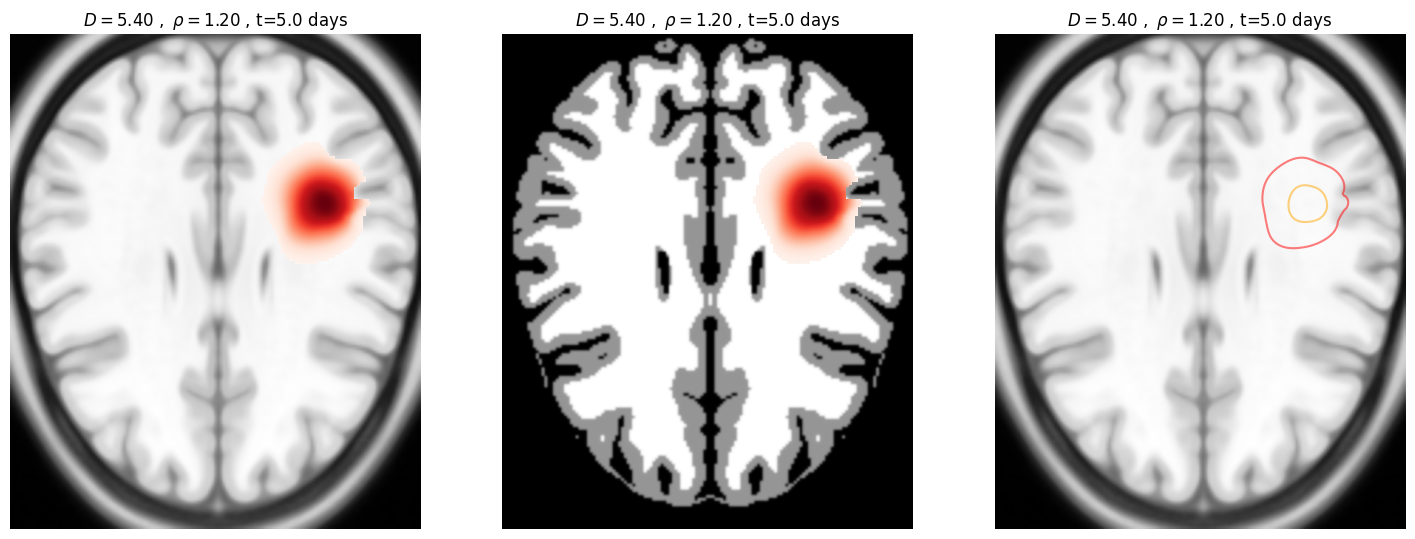

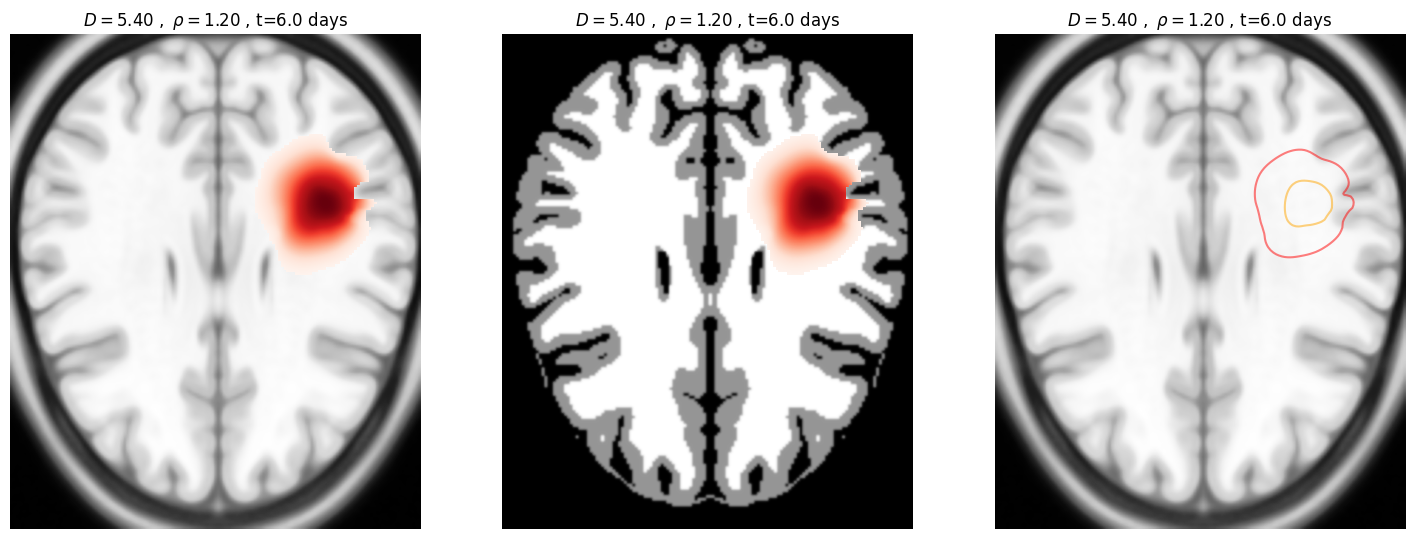

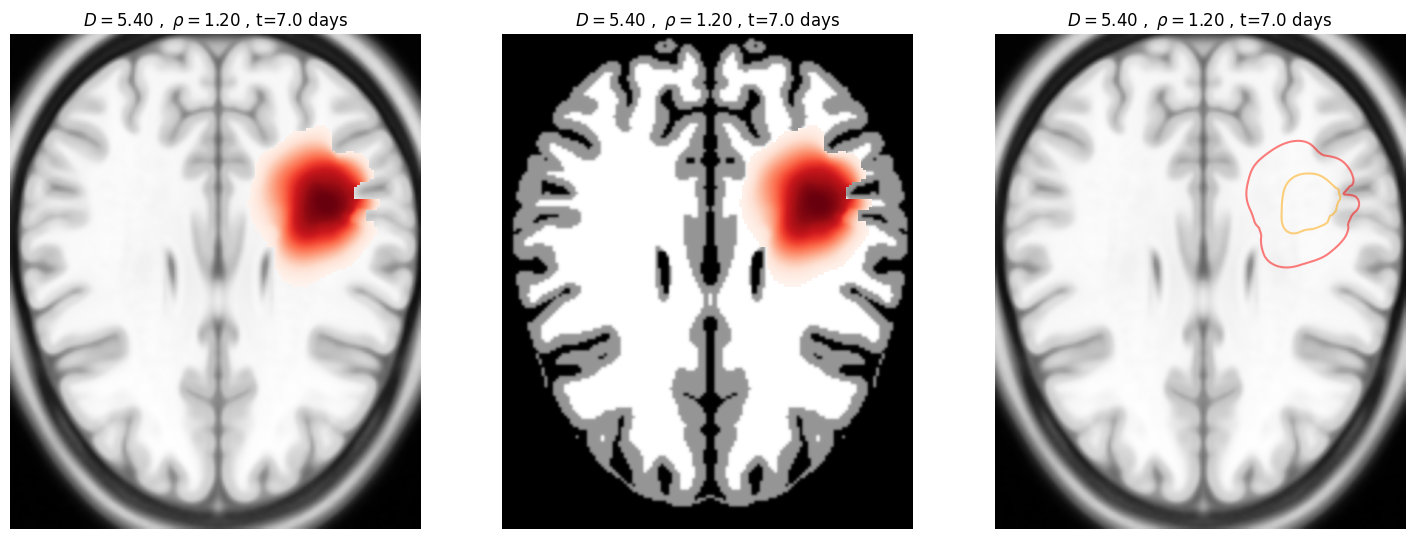

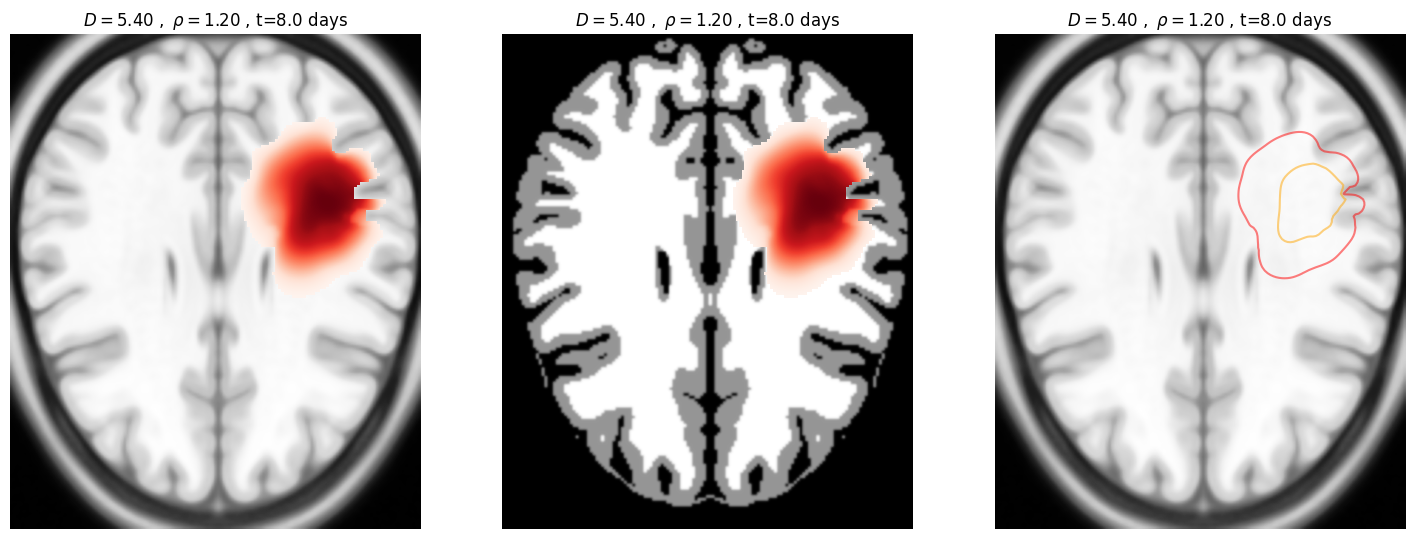

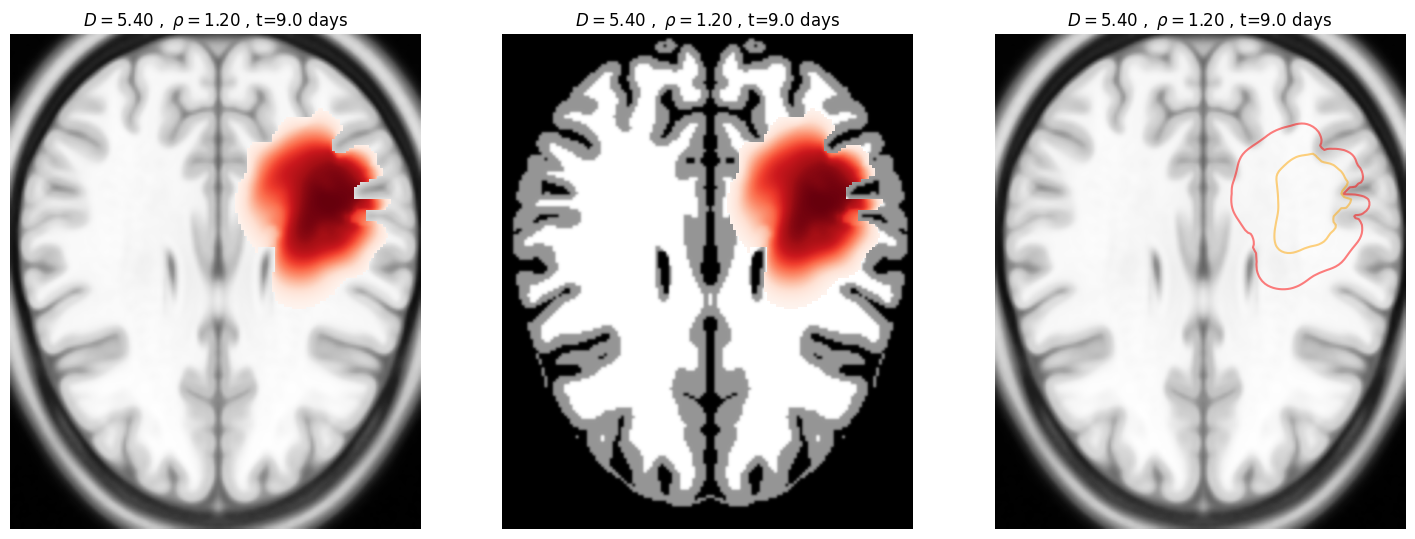

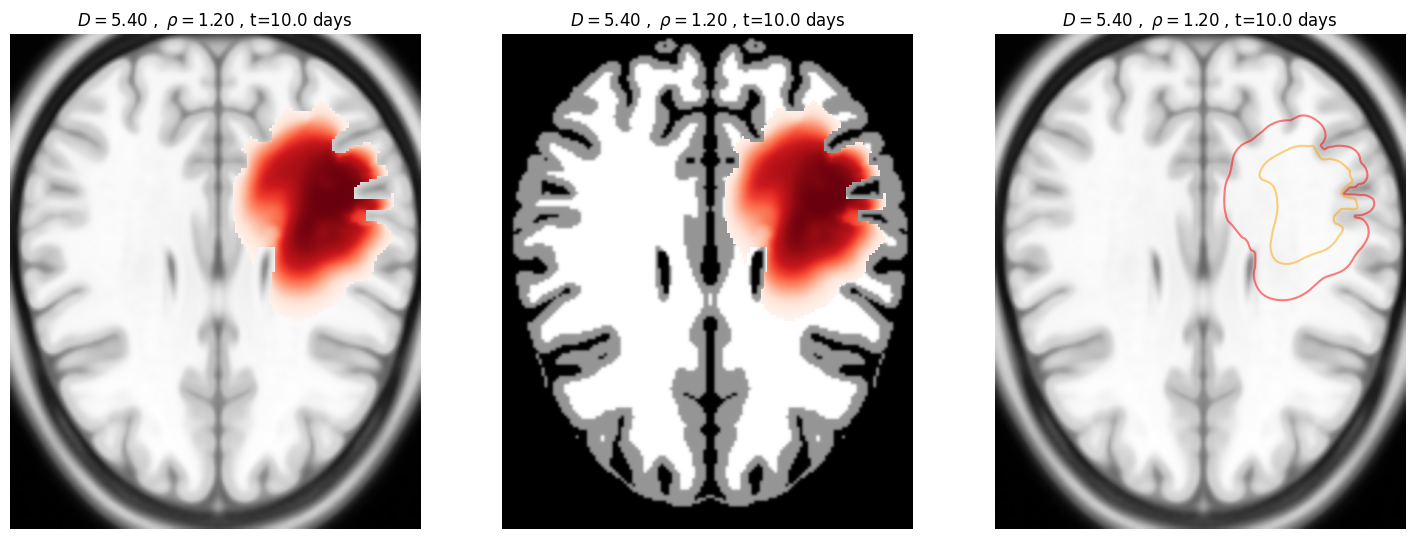

In [69]:
IRM_r = normalize_MRI(img)
IRM_b = IRM_r[27:48, 35:210, 25:170]
warnings.filterwarnings('ignore')
cnIRM = CNicholsonIRM3D(IRM_b, d_w=5.4, x0 = [10, 60, 110], rho=1.2, sigma=10, T=10.1)  # [95, 135]
cnIRM.simulation()

In [70]:
# Ahora `modelo.images` contiene las slices del cerebro y el tumor para cada época
for dia, slices in enumerate(cnIRM.images):
    print(f"Dia {dia}: {len(slices)} slices guardadas")

Dia 0: 21 slices guardadas
Dia 1: 21 slices guardadas
Dia 2: 21 slices guardadas
Dia 3: 21 slices guardadas
Dia 4: 21 slices guardadas
Dia 5: 21 slices guardadas
Dia 6: 21 slices guardadas
Dia 7: 21 slices guardadas
Dia 8: 21 slices guardadas
Dia 9: 21 slices guardadas
Dia 10: 21 slices guardadas


In [64]:
def plot_slice(day, slice_index, model):
    # Obtener la slice para el día y el índice de slice especificados
    if day >= len(model.images) or slice_index >= len(model.images[day]):
        print("El día o índice de slice especificado está fuera de los límites.")
        return

    combined = model.images[day][slice_index]
    brain_slice = combined[..., 0]
    tumor_slice = combined[..., 1]

    # Plotear la imagen
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(brain_slice, cmap=cm.Greys, interpolation='gaussian')
    tumor_mask = np.ma.masked_where(tumor_slice < 0.01, tumor_slice)
    ax.imshow(tumor_mask, cmap=cm.Reds, interpolation='gaussian', alpha=0.5)
    ax.set_title(f"Day {day}, Slice {slice_index}")
    plt.axis('off')
    plt.show()

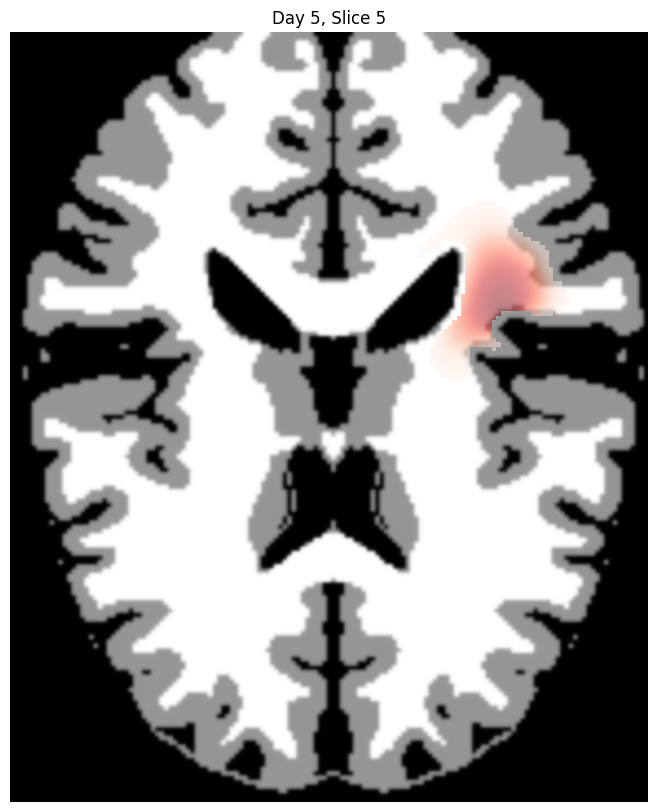

In [66]:
plot_slice(day=5, slice_index=5, model=cnIRM)

In [72]:
from scipy import interpolate

# Definir la matriz de afinidad consistente (esto es solo un ejemplo, ajusta según tus necesidades)
affine = np.array([
    [1, 0, 0, -95],   # Ancho, desplazado en -95 unidades en x
    [0, 1, 0, -116],  # Alto, desplazado en -116 unidades en y
    [0, 0, 1, -98],   # Profundidad, desplazado en -98 unidades en z
    [0, 0, 0, 1]
])

# Factor de interpolación para aumentar de 70 a 189 slices
factor_interpolacion = 189 / 70

# Supongamos que tienes las siguientes imágenes como arrays de NumPy
# img es la imagen de resonancia magnética completa
# cnIRM.images contiene las imágenes del cerebro y del tumor para cada día

# Ejemplo de img (imagen completa)
#img_nifti = nib.Nifti1Image(IRM_n[:, 35:210, 25:170], affine)
#nib.save(img_nifti, 'img.nii')

# Guardar las imágenes del cerebro y del tumor para cada día
for day in range(11):  # Suponiendo que tienes días de 0 a 2
    brain_slices = []
    tumor_slices = []
    
    for i in range(21):  # Suponiendo que tienes 21 slices por día
        combined = cnIRM.images[day][i]
        brain_slice = combined[..., 0]
        tumor_slice = combined[..., 1]
        
        brain_slices.append(brain_slice)
        tumor_slices.append(tumor_slice)
    
    # Convertir las listas de slices a arrays de NumPy
    brain_slices = np.array(brain_slices)
    tumor_slices = np.array(tumor_slices)
    
    # Crear y guardar las imágenes NIfTI
    brain_nifti = nib.Nifti1Image(brain_slices, affine)
    tumor_nifti = nib.Nifti1Image(tumor_slices, affine)
    
    nib.save(brain_nifti, f'cerebro_dia_{day}.nii')
    nib.save(tumor_nifti, f'tumor_dia_{day}.nii')

print("Imágenes guardadas con éxito.")


Imágenes guardadas con éxito.


In [73]:
from PIL import Image

# Lista de nombres de archivos
filenames = ["T-1.png", "T0.png","T1.png", "T2.png", "T3.png", "T4.png", "T5.png", "T6.png", "T7.png"]

# Lista para almacenar las imágenes
images = []

# Abrir cada imagen y agregarla a la lista
for filename in filenames:
    img = Image.open(filename)
    images.append(img)

# Guardar las imágenes como un GIF
images[0].save('output.gif',
               save_all=True,
               append_images=images[1:],
               duration=500,  # Duración en milisegundos entre cada frame
               loop=0)  # 0 significa que el GIF se repite para siempre

print("GIF creado con éxito.")


GIF creado con éxito.
